In [1]:
# scratch code to get atmsopheric forcing .nc files


from datetime import datetime, timedelta, date, time
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pygrib
from pydap.client import open_url
import netCDF4 as nc


In [2]:
# get roms grid for plotting

def roms_grid_to_dict(fng):
    gr = nc.Dataset(fng)    
    # get roms grid variables
    RM=dict()
    RM['lon_rho']=gr.variables['lon_rho'][:,:]
    RM['lat_rho']=gr.variables['lat_rho'][:,:]
    RM['lon_u']=gr.variables['lon_u'][:,:]
    RM['lat_u']=gr.variables['lat_u'][:,:]
    RM['lon_v']=gr.variables['lon_v'][:,:]
    RM['lat_v']=gr.variables['lat_v'][:,:]
    RM['h'] =gr.variables['h'][:,:]
    RM['mask_rho'] = gr.variables['mask_rho'][:,:]
    RM['mask_u'] = gr.variables['mask_u'][:,:]
    RM['mask_v'] = gr.variables['mask_v'][:,:]
    RM['angle'] = gr.variables['angle'][:,:]
    RM['angle_u'] = 0.5*(RM['angle'][:,0:-1]+RM['angle'][:,1:])
    RM['angle_v'] = 0.5*(RM['angle'][0:-1,:]+RM['angle'][1:,:])
    return RM


In [3]:
fore_date = '20240620'

# here is one way using opendap to get nomads data using pydap
# with this method the data is not downloaded directly, initially

# nam_nest is at 3 hr resolution, for 2.5 days
# 0.03 deg horizontal resolution, the grid is rectilinear in lon,lat
nam_nest = 'https://nomads.ncep.noaa.gov/dods/nam/nam' + fore_date + '/nam_conusnest_00z'

# nam_1hr is at 1 hr resolution, for 1.5 days
# 0.11 deg horizontal resolution
nam1hr = 'https://nomads.ncep.noaa.gov/dods/nam/nam' + fore_date + '/nam1hr_00z'

# hires_fv3 is at 1 hr resolution, for 2.5 days
# 0.05 deg horizontal resolution
# this one doesn't have short and long wave. DARN.
hires_fv3 = 'https://nomads.ncep.noaa.gov/dods/hiresw/hiresw' + fore_date + '/hiresw_conusfv3_00z'

# hrrr is at 1 hr resolution, for 2 days, for 00z forecast
# 0.03 deg horizontal resolution, same grid as nam_nest. 
hrrr = 'https://nomads.ncep.noaa.gov/dods/hrrr/hrrr' + fore_date + '/hrrr_sfc.t00z'

# gfs is at 1 hr resolution, for 5 days
# 0.25 deg horizontal resolution
gfs = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25_1hr/gfs' + fore_date + '/gfs_0p25_1hr_00z'


In [4]:
# to download all times, lats, lons, this would do it!
atm_name = nam_nest
dataset = open_url(atm_name)
# open_url is sometimes slow, and this block of code can be fast (1s), med (6s), or slow (>15s)


In [5]:
# set up the variables.
time  = dataset['time'] # ???
ln = dataset['lon'] # deg
lt = dataset['lat'] # deg
#Pres = dataset['pressfc'] # at surface, pa
Pres = dataset['prmslmsl'] # pressure at mean sea level.
Temp = dataset['tmpsfc'] # at surface, K
Hum  = dataset['rh2m'] # at 2 meters, %
U    = dataset['ugrd10m'] # at 10 meters, m/s
V    = dataset['vgrd10m'] # at 10 meters, m/s
if atm_name == nam_nest or atm_name == hrrr:
    Rain = dataset['pratesfc'] # at surface, kg/m2/s
if atm_name == nam1hr or atm_name == hires_fv3:
    Rain = dataset['apcpsfc'] # total precip, kg/m2, need to take diffs of times.    
Swd  = dataset['dswrfsfc'] # downward short-wave at surface, W/m2
Swu  = dataset['uswrfsfc'] # upward short-wave at surface, W/m2
Lwd  = dataset['dlwrfsfc'] # downward long-wave at surface, W/m2
Lwu  = dataset['ulwrfsfc'] # upward long-wave at surface, W/m2


In [6]:
# here we find the indices of the data we want for LV1
ln_min = -124.5
ln_max = -115
lt_min = 28
lt_max = 37
Ln0 = ln[:]
Lt0 = lt[:]
iln = np.where( (Ln0>=ln_min)*(Ln0<=ln_max) ) # the lon indices where we want data
ilt = np.where( (Lt0>=lt_min)*(Lt0<=lt_max) ) # the lat indices where we want data


In [7]:
pres2 = Pres[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]] # indexing looks bad but works
# t is days after Dec 31, 0000 ???? It seems.
# datevec(739055+datenum(1,1,-1)) =  2024  6  17
# t[0] = 739055  
t = pres2.time[:].data
lon = pres2.lon[:].data
lat = pres2.lat[:].data
pres = pres2.array[:,:,:].data

# we will get the other data directly
temp = Temp.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
hum = Hum.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
u = U.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
v = V.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
rain = Rain.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
swd = Swd.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
swu = Swu.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
lwd = Lwd.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data
lwu = Lwu.array[:,ilt[0][0]:ilt[0][-1],iln[0][0]:iln[0][-1]].data


In [8]:
fngr = '/Users/mspydell/research/FF2024/models/SDPM_mss/PFM_user/grids/GRID_SDTJRE_LV1.nc'
RMG = roms_grid_to_dict(fngr)

In [9]:
def plot_roms_box(axx,RMG):
    xr1 = RMG['lon_rho'][0,:]
    yr1 = RMG['lat_rho'][0,:]
    xr2 = RMG['lon_rho'][:,0]
    yr2 = RMG['lat_rho'][:,0]
    xr3 = RMG['lon_rho'][-1,:]
    yr3 = RMG['lat_rho'][-1,:]
    xr4 = RMG['lon_rho'][:,-1]
    yr4 = RMG['lat_rho'][:,-1]
    axx.plot(xr1,yr1,'k-',linewidth=.5)
    axx.plot(xr2,yr2,'k-',linewidth=.5)
    axx.plot(xr3,yr3,'k-',linewidth=.5)
    axx.plot(xr4,yr4,'k-',linewidth=.5)

def plot_roms_coastline(axx,RMG):
    axx.contour(RMG['lon_rho'],RMG['lat_rho'],RMG['h'],levels=[5, 10],colors='k')

Text(0.5, 1.0, 'atm surface temp (K)')

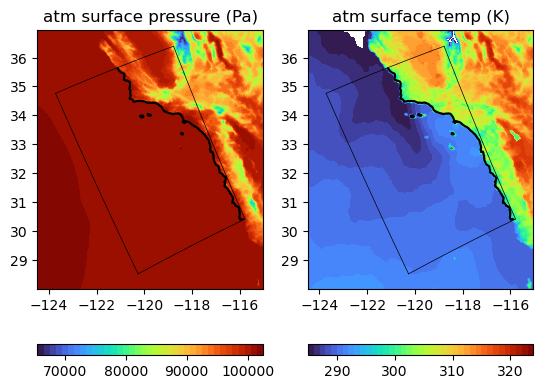

In [10]:
# check the pressure and temperature
fig, axs = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(6.55e4,1.03e5,1e3)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(lon,lat,pres[0,:,:],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(np.arange(7e4,1.1e5,1e4))
axs[0].set_title('atm surface pressure (Pa)')

plevs=np.arange(285,325,1)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[1].contourf(lon,lat,temp[0,:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
cbar.set_ticks(np.arange(290,330,10))
axs[1].set_title('atm surface temp (K)')


Text(0.5, 1.0, 'long wave up (W/m2)')

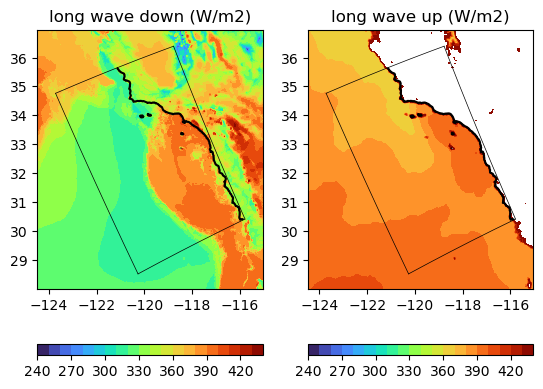

In [11]:
# check lwup and lwdown
fig, axs = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(2.4e2,4.5e2,10)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(lon,lat,lwd[0,:,:],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
#cbar.set_ticks(np.arange(7e4,1.1e5,1e4))
axs[0].set_title('long wave down (W/m2)')

plevs=np.arange(2.4e2,4.5e2,10)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[1].contourf(lon,lat,lwu[0,:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
#cbar.set_ticks(np.arange(290,330,10))
axs[1].set_title('long wave up (W/m2)')



Text(0.5, 1.0, 'short wave up (W/m2)')

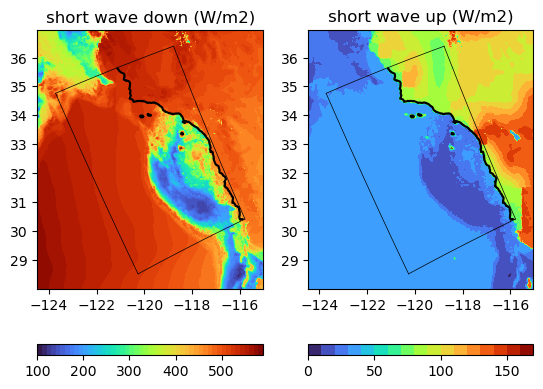

In [12]:
# check swup and swdown
fig, axs = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(1e2,6e2,10)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(lon,lat,swd[0,:,:],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(np.arange(1e2,6e2,1e2))
axs[0].set_title('short wave down (W/m2)')

plevs=np.arange(0,1.8e2,10)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[1].contourf(lon,lat,swu[0,:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
cbar.set_ticks(np.arange(0,2e2,50))
axs[1].set_title('short wave up (W/m2)')



Text(0.5, 1.0, 'surface humidity (%)')

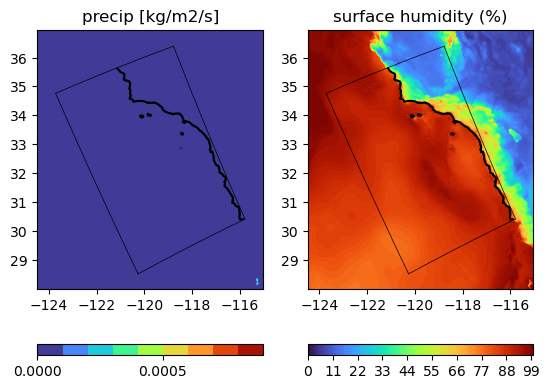

In [13]:
# check rain and humidity
fig, axs = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(0,.001,.0001)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(lon,lat,rain[0,:,:],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(np.arange(0,.001,.0005))
axs[0].set_title('precip [kg/m2/s]')

plevs=np.arange(0,101,1)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[1].contourf(lon,lat,hum[0,:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
#cbar.set_ticks(np.arange(0,2e2,50))
axs[1].set_title('surface humidity (%)')


Text(0.5, 1.0, '10 m velocity [m/s, every 10 grid points]')

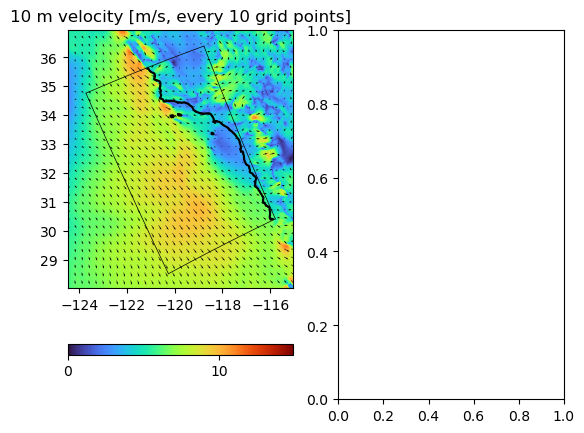

In [14]:
# finally velocity
fig, axs = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(0,15,.1)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(lon,lat,(u[0,:,:]**2 +v[0,:,:]**2)**0.5,plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
axs[0].quiver(lon[0:-1:10],lat[0:-1:10],u[0,0:-1:10,0:-1:10],v[0,0:-1:10,0:-1:10])
#axs[0].quiver(-123,31,7,-7,color='w') direction looks right
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(np.arange(0,20,10))
axs[0].set_title('10 m velocity [m/s, every 10 grid points]')




In [47]:
# the code in here goes from the start date to all forecast dates
#d1=datetime(2024,6,17) # a datetime object, the date is the date of forecast
d1=datetime.fromisoformat(fore_date)
print(d1)
t2 = t-t[0] # an ndarray of days, t is from atm import
print(len(t2))
t3 = d1 + t2 * timedelta(days=1)
print(t3)
# t3 looks good and is the correct time stamps of the forecast.
# But for ROMS we need ocean_time which is relative to 1970,1,1. 
# in seconds. So...
t_roms0 = datetime(1970,1,1)
tr = t3 - t_roms0
tr_sec = tr.astype("timedelta64[ms]").astype(float) / 1000 / 3600 / 24
# tr_sec is now an ndarray of days past the reference day
print(tr_sec)


2024-06-20 00:00:00
49
[datetime.datetime(2024, 6, 20, 0, 0)
 datetime.datetime(2024, 6, 20, 0, 59, 59, 999997)
 datetime.datetime(2024, 6, 20, 2, 0, 0, 3)
 datetime.datetime(2024, 6, 20, 3, 0)
 datetime.datetime(2024, 6, 20, 3, 59, 59, 999997)
 datetime.datetime(2024, 6, 20, 5, 0, 0, 3)
 datetime.datetime(2024, 6, 20, 6, 0)
 datetime.datetime(2024, 6, 20, 6, 59, 59, 999997)
 datetime.datetime(2024, 6, 20, 8, 0, 0, 3)
 datetime.datetime(2024, 6, 20, 9, 0)
 datetime.datetime(2024, 6, 20, 9, 59, 59, 999997)
 datetime.datetime(2024, 6, 20, 11, 0, 0, 3)
 datetime.datetime(2024, 6, 20, 12, 0)
 datetime.datetime(2024, 6, 20, 12, 59, 59, 999997)
 datetime.datetime(2024, 6, 20, 14, 0, 0, 3)
 datetime.datetime(2024, 6, 20, 15, 0)
 datetime.datetime(2024, 6, 20, 15, 59, 59, 999997)
 datetime.datetime(2024, 6, 20, 17, 0, 0, 3)
 datetime.datetime(2024, 6, 20, 18, 0)
 datetime.datetime(2024, 6, 20, 18, 59, 59, 999997)
 datetime.datetime(2024, 6, 20, 20, 0, 0, 3)
 datetime.datetime(2024, 6, 20, 21, 

(0.0, 0.1)

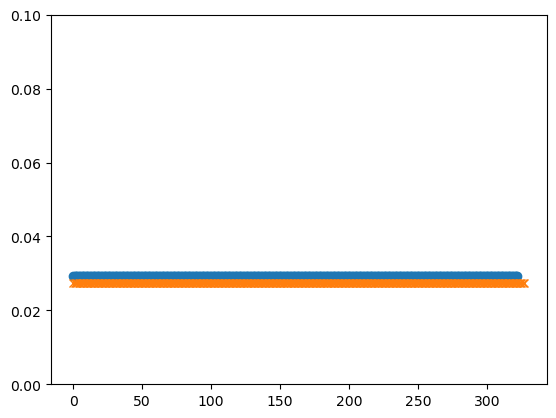

In [48]:
fig, axs = plt.subplots()

#print(lon[1])
#print(lon[0])
#print(lon[1]-lon[0])
#print(np.diff(lon))
#print(np.shape(lon))
axs.plot(np.diff(lon),'o')
axs.plot(np.diff(lat),'x')
axs.set_ylim([0,.1])



In [15]:
# now do the direct download method, and move the files
import wget
import os

sys.path.append('/opt/homebrew/Cellar/nceplibs-g2c/1.9.0/lib')
# surface stuff first
url = 'https://nomads.ncep.noaa.gov/cgi-bin/filter_nam_conusnest.pl?dir=%2Fnam.' + fore_date + '&file=nam.t00z.conusnest.hiresf00.tm00.grib2&var_DLWRF=on&var_DSWRF=on&var_PRATE=on&var_PRES=on&var_RH=on&var_TMP=on&var_ULWRF=on&var_USWRF=on&lev_surface=on&subregion=&toplat=37&leftlon=-124.5&rightlon=-115.0&bottomlat=28'
fname = wget.download(url)
print(fname)
fn1 = './' + fname
fn2 = '/Users/mspydell/research/FF2024/models/SDPM_mss/atm_stuff/' + fore_date + fname
os.rename(fn1,fn2)

# 10 m velocity is done separately
url_uv = 'https://nomads.ncep.noaa.gov/cgi-bin/filter_nam_conusnest.pl?dir=%2Fnam.' + fore_date + '&file=nam.t00z.conusnest.hiresf00.tm00.grib2&var_RH=on&var_UGRD=on&var_VGRD=on&lev_10_m_above_ground=on&subregion=&toplat=37&leftlon=-124.5&rightlon=-115.0&bottomlat=28'
fname_uv = wget.download(url_uv)
print(fname_uv)
fn1 = './' + fname_uv
fn2_uv = '/Users/mspydell/research/FF2024/models/SDPM_mss/atm_stuff/' + fore_date + '_uv_' + fname_uv
os.rename(fn1,fn2_uv)

url_hum='https://nomads.ncep.noaa.gov/cgi-bin/filter_nam_conusnest.pl?dir=%2Fnam.' + fore_date + '&file=nam.t00z.conusnest.hiresf00.tm00.grib2&var_RH=on&lev_2_m_above_ground=on&subregion=&toplat=37&leftlon=-124.5&rightlon=-115&bottomlat=28'
fname_hum = wget.download(url_hum)
print(fname_hum)
fn1 = './' + fname_hum
fn2_hum = '/Users/mspydell/research/FF2024/models/SDPM_mss/atm_stuff/' + fore_date + '_hum_' + fname_uv
os.rename(fn1,fn2_hum)




nam.t00z.conusnest.hiresf00.tm00.grib2
nam.t00z.conusnest.hiresf00.tm00.grib2
nam.t00z.conusnest.hiresf00.tm00.grib2


In [16]:
# now load up the data.
data = pygrib.open(fn2)
data.seek(0)
for mm in data:
    print(mm)
data.seek(0)

data_uv = pygrib.open(fn2_uv)
data_uv.seek(0)
for mm in data_uv:
    print(mm)
data_uv.seek(0)

data_hum = pygrib.open(fn2_hum)
data_hum.seek(0)
for mm in data_hum:
    print(mm)
data_hum.seek(0)



1:Surface pressure:Pa (instant):lambert:surface:level 0:fcst time 0 hrs:from 202406200000
2:Temperature:K (instant):lambert:surface:level 0:fcst time 0 hrs:from 202406200000
3:Precipitation rate:kg m**-2 s**-1 (instant):lambert:surface:level 0:fcst time 0 hrs:from 202406200000
4:Downward short-wave radiation flux:W m**-2 (avg):lambert:surface:level 0:fcst time 0 hrs (avg):from 202406200000
5:Downward long-wave radiation flux:W m**-2 (avg):lambert:surface:level 0:fcst time 0 hrs (avg):from 202406200000
6:Upward short-wave radiation flux:W m**-2 (avg):lambert:surface:level 0:fcst time 0 hrs (avg):from 202406200000
7:Upward long-wave radiation flux:W m**-2 (avg):lambert:surface:level 0:fcst time 0 hrs (avg):from 202406200000
8:Downward short-wave radiation flux:W m**-2 (instant):lambert:surface:level 0:fcst time 0 hrs:from 202406200000
9:Downward long-wave radiation flux:W m**-2 (instant):lambert:surface:level 0:fcst time 0 hrs:from 202406200000
10:Upward short-wave radiation flux:W m**-2

In [17]:
# grab the data

pres = data[1].values
temp = data[2].values
u10   = data_uv[1].values
v10   = data_uv[2].values
rain = data[3].values
swd_a = data[4].values
lwd_a = data[5].values
swu_a = data[6].values
lwu_a = data[7].values
hum   = data_hum[1].values
#swd_i = data[8].values
#lwd_i = data[9].values
#swu_i = data[10].values
#lwu_i = data[11].values
Lt,Ln = data[1].latlons()


Text(0.5, 1.0, 'atm surface temp, grb (K)')

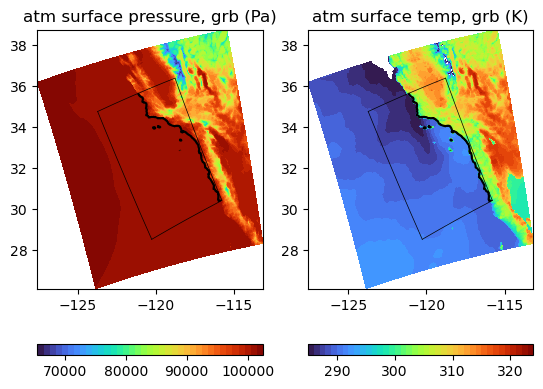

In [18]:
# check the pressure and temperature
fig, axs = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(6.55e4,1.03e5,1e3)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(Ln,Lt,pres[:,:],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(np.arange(7e4,1.1e5,1e4))
axs[0].set_title('atm surface pressure, grb (Pa)')

plevs=np.arange(285,325,1)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[1].contourf(Ln,Lt,temp[:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
cbar.set_ticks(np.arange(290,330,10))
axs[1].set_title('atm surface temp, grb (K)')


Text(0.5, 1.0, 'long wave up (W/m2)')

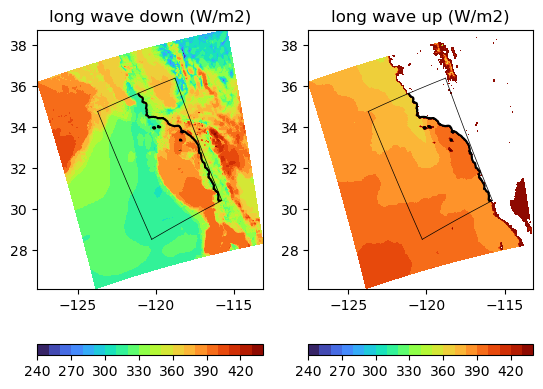

In [19]:
# check lwup and lwdown
fig, axs = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(2.4e2,4.5e2,10)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(Ln,Lt,lwd_a[:,:],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
#cbar.set_ticks(np.arange(7e4,1.1e5,1e4))
axs[0].set_title('long wave down (W/m2)')

plevs=np.arange(2.4e2,4.5e2,10)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[1].contourf(Ln,Lt,lwu_a[:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
#cbar.set_ticks(np.arange(290,330,10))
axs[1].set_title('long wave up (W/m2)')




Text(0.5, 1.0, 'short wave up (W/m2)')

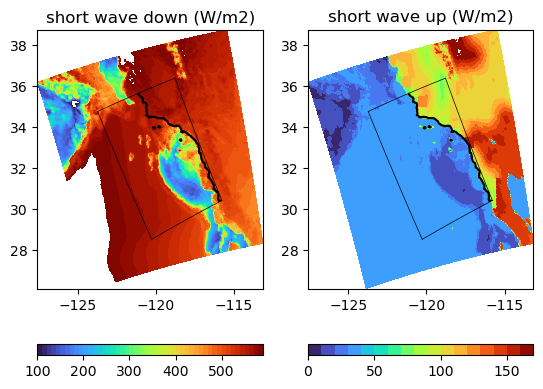

In [20]:
# check swup and swdown
fig, axs = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(1e2,6e2,10)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(Ln,Lt,swd_a[:,:],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(np.arange(1e2,6e2,1e2))
axs[0].set_title('short wave down (W/m2)')

plevs=np.arange(0,1.8e2,10)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[1].contourf(Ln,Lt,swu_a[:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
cbar.set_ticks(np.arange(0,2e2,50))
axs[1].set_title('short wave up (W/m2)')



Text(0.5, 1.0, 'surface humidity (%)')

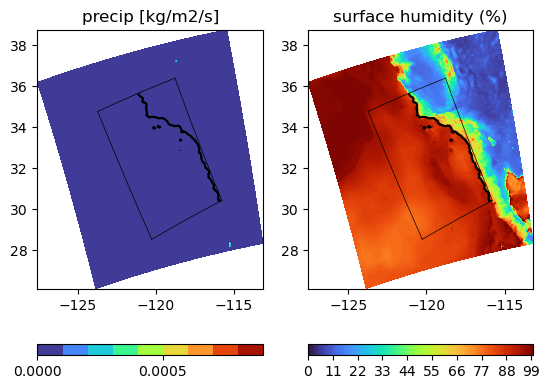

In [21]:
# check rain and humidity
fig, axs = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(0,.001,.0001)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(Ln,Lt,rain[:,:],plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(np.arange(0,.001,.0005))
axs[0].set_title('precip [kg/m2/s]')

plevs=np.arange(0,101,1)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[1].contourf(Ln,Lt,hum[:,:],plevs)
plot_roms_box(axs[1],RMG)
plot_roms_coastline(axs[1],RMG)
cbar=fig.colorbar(cset1,ax=axs[1],orientation='horizontal')
#cbar.set_ticks(np.arange(0,2e2,50))
axs[1].set_title('surface humidity (%)')


Text(0.5, 1.0, '10 m velocity [m/s, every 10 grid points]')

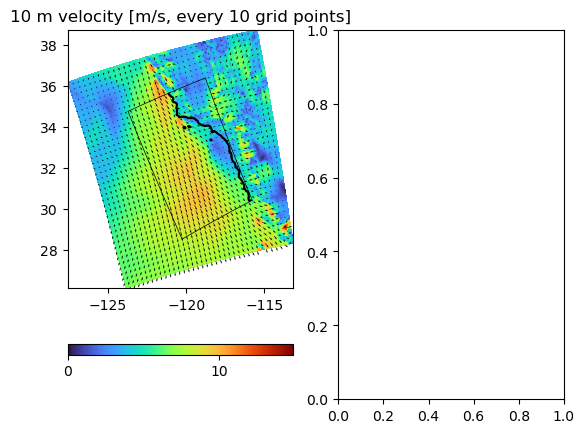

In [22]:
# finally velocity
# NOTICE velocities using the grib file are in the (xi,eta) direction of the model
# not north south. An additional rotation is required as done in the ncei_2roms.m
# code.
fig, axs = plt.subplots(nrows=1, ncols=2)

plevs=np.arange(0,15,.1)
cmap=plt.get_cmap('turbo')
plt.set_cmap(cmap)
cset1=axs[0].contourf(Ln,Lt,(u10[:,:]**2 +v10[:,:]**2)**0.5,plevs)
plot_roms_box(axs[0],RMG)
plot_roms_coastline(axs[0],RMG)
axs[0].quiver(Ln[0:-1:10,0:-1:10],Lt[0:-1:10,0:-1:10],u10[0:-1:10,0:-1:10],v10[0:-1:10,0:-1:10])
#axs[0].quiver(-123,31,7,-7,color='w') direction looks right
cbar=fig.colorbar(cset1,ax=axs[0],orientation='horizontal')
cbar.set_ticks(np.arange(0,20,10))
axs[0].set_title('10 m velocity [m/s, every 10 grid points]')

